In [1]:
# Source: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
# Import python libraries

import pandas as pd
pd.set_option('display.max_columns', 999,'display.max_rows', 999)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## Load and check data

In [2]:
# Import data

init_train_data = pd.read_csv("train.csv", delimiter =",")
init_test_data = pd.read_csv("test.csv", delimiter = ",")

In [3]:
init_train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C


In [4]:
# Method to detect the outliers
# We only detect the outliers from the features Age, SibSP, Parch and Fare because they
# are the ones in which an outlier can affect the most our prediction

def outlier_detector(df, n, features):
    """
    df: dataframe to examine
    n: min number of features in which the datapoint should have an outlier to be selected
    features: features of the dataframe to be examined
    """
    outlier_indices = []
    
    # iterate over the selected features
    
    for col in features:
        #print("col: ", col)
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3-Q1
        
        # Outlier step
        step = 1.5*IQR
        
        # For every feature determine a list of outliers
        outlier_list_col = df[(df[col]<Q1 - step) | (df[col]> Q3 + step)].index
        
        #print("outlier list col: ", outlier_list_col)
        
        # Append the outliers found for the specific feature to the general outlier list
        outlier_indices.extend(outlier_list_col)
        #print("outlier indices: ", outlier_indices)
        
    # Select the observations that have outliers in more than n features
    outlier_indices = Counter(outlier_indices)
    #print("outlier indices final: ", outlier_indices)
    post_outliers = list(k for k,v in outlier_indices.items() if v>n)
    
    return post_outliers

outliers = outlier_detector(init_train_data, 2, ["Age","SibSp","Parch","Fare"])
print("Outliers to drop: ", outliers)

Outliers to drop:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [5]:
# We drop the outliers from the training data set
init_train_data =init_train_data.drop(outliers, axis = 0). reset_index(drop=True)

In [6]:
# Join test and training datasets to have the full range of categorical values during conversion
train_len = len(init_train_data)
dataset = pd.concat(objs = [init_train_data,init_test_data], axis=0).reset_index(drop=True)

In [7]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [8]:
# Check for null and missing values

# Replace NaNs for np NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [10]:
# More information about training data

init_train_data.info()
init_train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
# Training data statistics

init_train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [12]:
# Whole dataset statistics
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1299.000000,881.000000,1299.000000,1043.000000,1299.000000,1299.000000,1298.000000
mean,657.093149,0.385925,2.294072,29.903806,0.452656,0.372594,32.569058
std,377.743244,0.487090,0.837150,14.427548,0.879416,0.857157,50.694652
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,331.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,657.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,984.500000,1.000000,3.000000,39.000000,1.000000,0.000000,30.646850
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## Feature analysis

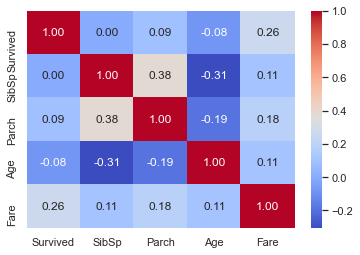

In [13]:
# Correlation matrix between numerical values

g = sns.heatmap(init_train_data[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


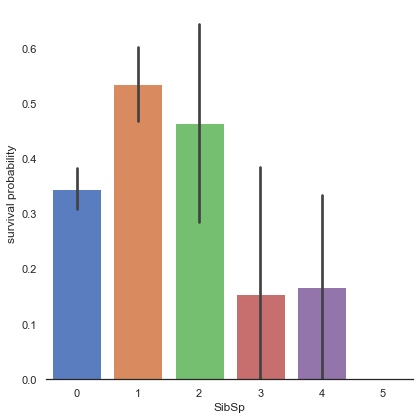

In [14]:
# SibSP feature vs Survived

g = sns.factorplot(x="SibSp",y="Survived",data=init_train_data,kind="bar", height= 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

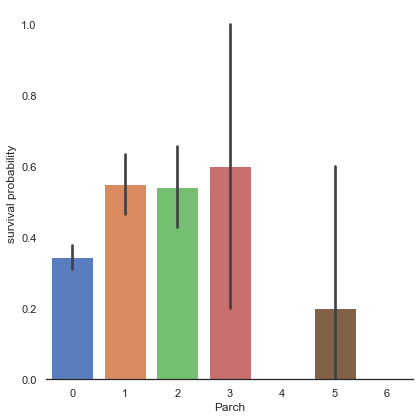

In [15]:
# Let's explore Parch feature vs Survived

g = sns.factorplot(x="Parch",y="Survived",data=init_train_data,kind="bar", height= 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

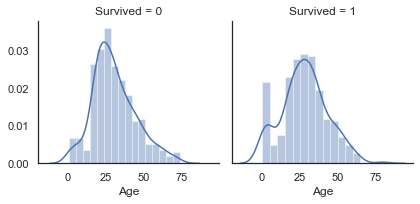

In [16]:
# Age vs Survived
g = sns.FacetGrid(init_train_data, col='Survived')
g = g.map(sns.distplot, "Age")

In [17]:
# Analyse Fare

# Null values
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill it with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

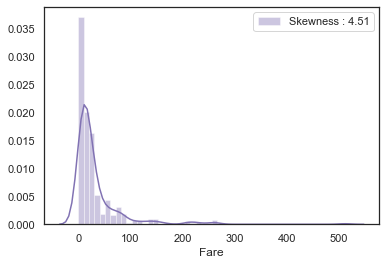

In [19]:
# Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i:np.log(i) if i>0 else 0)

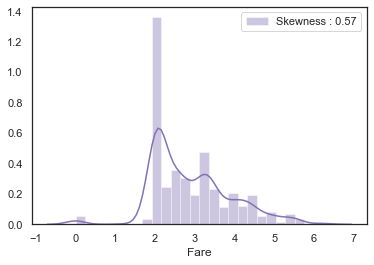

In [21]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

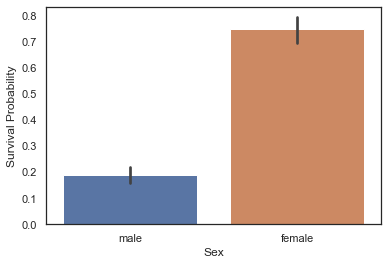

In [22]:
# Categorical Values
# Sex
g = sns.barplot(x="Sex",y="Survived",data=init_train_data)
g = g.set_ylabel("Survival Probability")

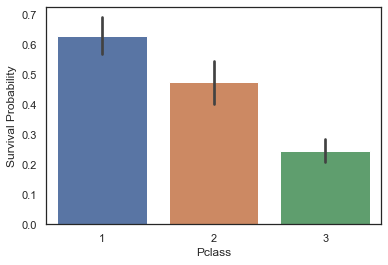

In [23]:
# Pclass
g = sns.barplot(x="Pclass",y="Survived",data=init_train_data)
g = g.set_ylabel("Survival Probability")

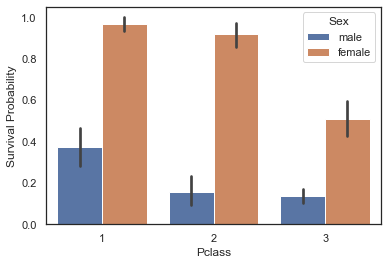

In [24]:
# Explore Pclass vs Survived by Sex
g = sns.barplot(x="Pclass",y="Survived", hue="Sex",data=init_train_data)
g = g.set_ylabel("Survival Probability")

In [25]:
# Embarked

# Null values
dataset["Embarked"].isnull().sum()

2

In [26]:
# Fill with the most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

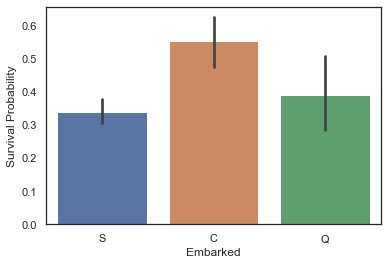

In [27]:
# Plot survival vs Embarked
g = sns.barplot(x="Embarked",y="Survived",data=init_train_data)
g = g.set_ylabel("Survival Probability")

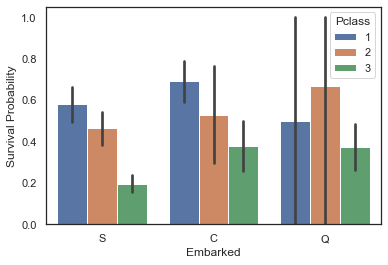

In [28]:
# Plot the class relationship with the embarking place
g = sns.barplot(x="Embarked",y="Survived", hue="Pclass",data=init_train_data)
g = g.set_ylabel("Survival Probability")

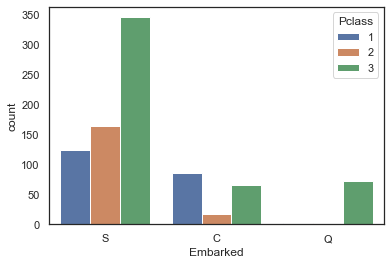

In [29]:
# The amount of people of each class embarked in each place
g = sns.countplot(data=init_train_data, x ="Embarked", hue="Pclass")

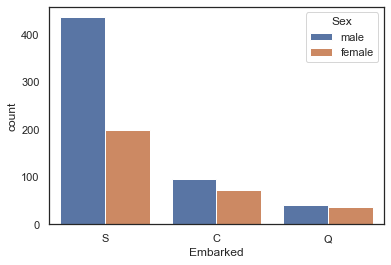

In [30]:
# The amount of people of each sex embarked in each place
g = sns.countplot(data=init_train_data, x ="Embarked", hue="Sex")

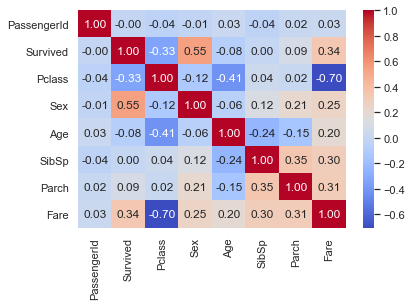

In [31]:
# Filling missing values
# For that we need to first check the correlation of this feature with the others
# Convert Sex into categorical
dataset["Sex"]= dataset["Sex"].map({"male":0,"female":1})
g = sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [32]:
# Fill missing Age values

# Get the indices of Nan age values
Nan_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in Nan_age:
    median = dataset["Age"].median()
    pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"]) & (dataset["Pclass"] == dataset.iloc[i]["Pclass"])& (dataset["Fare"] == dataset.iloc[i]["Fare"])&(dataset["Parch"] == dataset.iloc[i]["Parch"]))].median()
    
    if np.isnan(pred):
        dataset["Age"].iloc[i] = median 
    else:
        dataset["Age"].iloc[i] = pred

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\pyth

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\pyth

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

## Feature Engineering

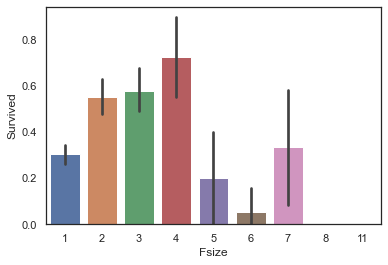

In [33]:
# Creation of family size feature as the sum of SibSp + Parch + 1(oneself)
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Let's plot the new feature
g = sns.barplot(x = "Fsize", y = "Survived", data=dataset)

In [34]:
# Encode categorical data

# Class
class_encoder = LabelEncoder()
class_to_encode = dataset["Pclass"]
class_encoded = class_encoder.fit_transform(class_to_encode)

# Embarked
embark_encoder = LabelEncoder()
embark_to_encode = dataset["Embarked"]
embark_encoded = embark_encoder.fit_transform(embark_to_encode)

# Replace in the features in dataset

dataset["Pclass"]=class_encoded
dataset["Embarked"] = embark_encoded

In [35]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fsize
0,1,0.0,2,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,2,2
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,0,2
2,3,1.0,2,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,2,1
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,2,2
4,5,0.0,2,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,2,"Spector, Mr. Woolf",0,28.0,0,0,A.5. 3236,2.085672,NaN,2,1
1295,1306,NaN,0,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,4.690430,C105,0,1
1296,1307,NaN,2,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,2,1
1297,1308,NaN,2,"Ware, Mr. Frederick",0,28.0,0,0,359309,2.085672,NaN,2,1


In [36]:
# Checking cabin feature
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [37]:
# Count the number of empty cabins
dataset["Cabin"].isnull().sum()

1007

In [38]:
# Assign all cabins a letter and if there is not a value assign Z
dataset["Cabin"]=pd.Series([i[0] if not pd.isnull(i) else "Z" for i in dataset["Cabin"]])

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


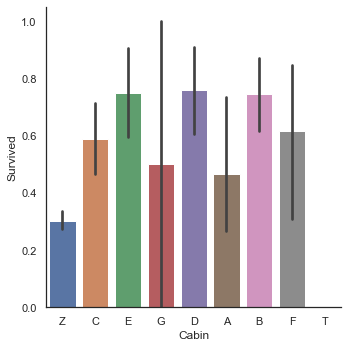

In [39]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar")

In [40]:
# Categorize the cabin data
cabin_encoder = LabelEncoder()
cabin_to_encode = dataset["Cabin"]
cabin_encoded = cabin_encoder.fit_transform(cabin_to_encode)

# Replace in the features in dataset

dataset["Cabin"]=cabin_encoded

In [41]:
# Get only the ticket prefix
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [42]:
# Categorize the ticket data
ticket_encoder = LabelEncoder()
ticket_to_encode = dataset["Cabin"]
ticket_encoded = ticket_encoder.fit_transform(ticket_to_encode)

# Replace in the features in dataset

dataset["Ticket"]=ticket_encoded


In [43]:
dataset["Ticket"].describe()

count    1299.000000
mean        6.733641
std         2.451665
min         0.000000
25%         8.000000
50%         8.000000
75%         8.000000
max         8.000000
Name: Ticket, dtype: float64

In [44]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fsize
0,1,0.0,2,"Braund, Mr. Owen Harris",0,22.0,1,0,8,1.981001,8,2,2
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,2,4.266662,2,0,2
2,3,1.0,2,"Heikkinen, Miss. Laina",1,26.0,0,0,8,2.070022,8,2,1
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,2,3.972177,2,2,2
4,5,0.0,2,"Allen, Mr. William Henry",0,35.0,0,0,8,2.085672,8,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,2,"Spector, Mr. Woolf",0,28.0,0,0,8,2.085672,8,2,1
1295,1306,NaN,0,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,2,4.690430,2,0,1
1296,1307,NaN,2,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,8,1.981001,8,2,1
1297,1308,NaN,2,"Ware, Mr. Frederick",0,28.0,0,0,8,2.085672,8,2,1


In [45]:
data_Id=dataset["PassengerId"]
dataset = dataset.drop(labels=["PassengerId", "Name"], axis=1)

## Modeling

In [46]:
# Separate train and test data
train = dataset[:train_len]
test = dataset[train_len:]
test_Id = data_Id[train_len:].values

# Separate labels from features
test.drop(labels = ["Survived"], axis=1, inplace=True)

Y_train = train["Survived"].astype(int)
X_train = train.drop(labels=["Survived"],axis=1)

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [47]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fsize
0,2,0,22.00,1,0,8,1.981001,8,2,2
1,0,1,38.00,1,0,2,4.266662,2,0,2
2,2,1,26.00,0,0,8,2.070022,8,2,1
3,0,1,35.00,1,0,2,3.972177,2,2,2
4,2,0,35.00,0,0,8,2.085672,8,2,1
5,2,0,28.00,0,0,8,2.135148,8,1,1
6,0,0,54.00,0,0,4,3.948596,4,2,1
7,2,0,2.00,3,1,8,3.048088,8,2,5
8,2,1,27.00,0,2,8,2.409941,8,2,3
9,1,1,14.00,1,0,8,3.403555,8,0,2


In [48]:
# Comparison of the performance of different models using cross validation

kfold = StratifiedKFold(n_splits=5)

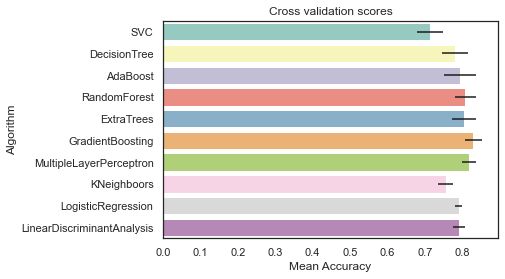

In [49]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state,probability=True))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\bcabg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

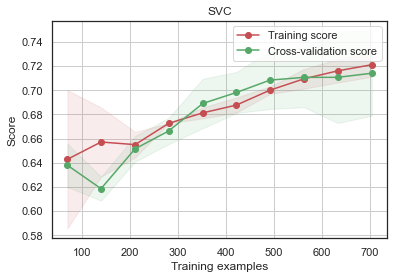

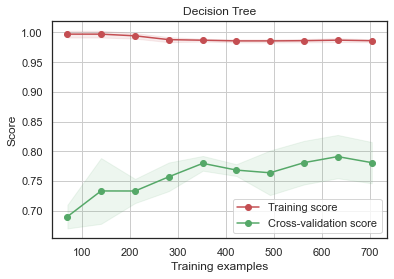

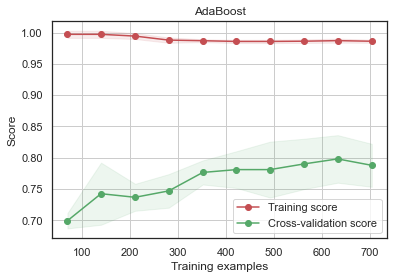

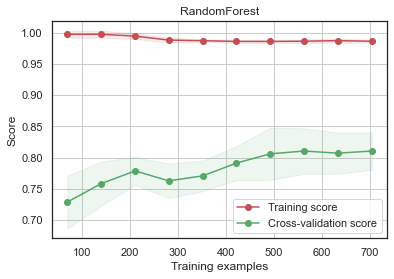

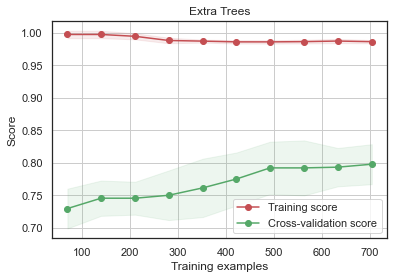

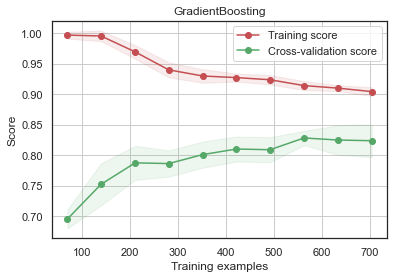

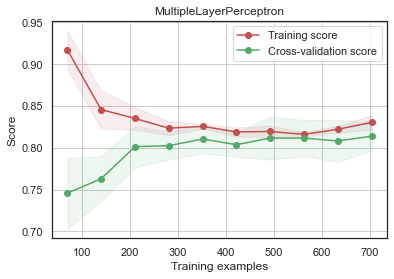

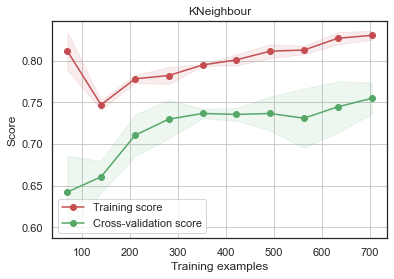

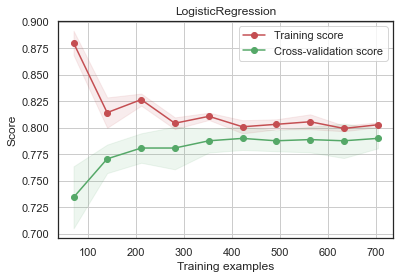

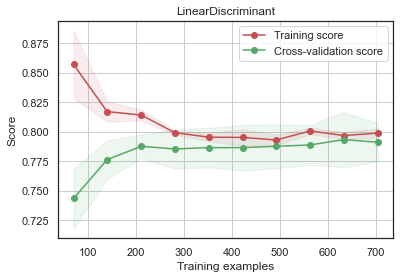

In [50]:
# Plot the learning curves of the trained classifiers

def plot_learning(estimator, title, X,y,train_sizes=np.linspace(.1,1.0,10), cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X,y,train_sizes=train_sizes, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

classifier_names = ["SVC","Decision Tree","AdaBoost", "RandomForest","Extra Trees","GradientBoosting","MultipleLayerPerceptron", "KNeighbour", "LogisticRegression","LinearDiscriminant"]

for i,classifier in enumerate(classifiers):
    
    t = plot_learning(classifier, classifier_names[i], X_train, Y_train, cv=kfold)


## Ensemble modelling

In [51]:
# Combining different models that didn't overfit

voting = VotingClassifier(estimators=[("Linear Discriminant", classifiers[9]),("KN", classifiers[7]),("MLP", classifiers[6]),("SVM",classifiers[0])], voting = "soft")
votingC = voting.fit(X_train, Y_train)
prediction = votingC.predict(test)
print(prediction)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1
 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 1 1 1 1 1 0 0 1 0 0 0]


## Prediction

In [52]:
results = pd.DataFrame(columns=["PassengerId"], data=test_Id)
results["Survived"] = prediction
results
results.to_csv("ensemble_titanic_results", index=False, sep=",")

In [53]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
